#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import datetime
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Анализ данных - тренды сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Модели машинного обучения для задач регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
# Метрики регрессии - оценка моделей
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
# Проверка моделей на вменяемость
from sklearn.dummy import DummyRegressor
# Для разделения данных на обучающий, тестовый набор данных. 
from sklearn.model_selection import train_test_split,GridSearchCV
# Кросс-валидация
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Откроем, изучим и подготовим файл.

In [2]:
df= pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
print('Количество пропусков: ')
print( df.isna().sum())
print()
print('Количество дубликатов: ')
print( df.duplicated().sum())

Количество пропусков: 
datetime      0
num_orders    0
dtype: int64

Количество дубликатов: 
0


*Дубликатов и пропусков нет. Предобработки не требуется.*

In [5]:
df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Выполним ресемплирование данных по одному часу:


In [6]:
df = df.resample('1h').sum().sort_index()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


***Проверим что индексы указаны в хронологическом порядке:***

In [7]:
if df.index.is_monotonic == True:
    print('Порядок хронологический')
else:
    print('Нужно упорядочить')

Порядок хронологический


In [8]:
print('Временные рамки, которые охватывает датафрейм: с ',  df.index.min(), 'по', df.index.max())

Временные рамки, которые охватывает датафрейм: с  2018-03-01 00:00:00 по 2018-08-31 23:00:00


In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод.

Был открыт и изучен датафрейм: изначально он состоял из  26496 строк и двух столбцов - типа *datetime* с интервалом в 10 минут и количеством заказов, приходящимся на это время. Охваченный временной интервал: 2018-03-01 00:00:00 по 2018-08-31 23:00:00, т е 6 месяцев. На этапе предобработки столбец *datetime* был установлен как индекс для удобства работы с датасетом. Пропущенных значений и дубликатов не обнаружено. Данные расположены в хронологическом порядке. *Т к требуются предсказания на следующий час, было проведено ресемплирование данных на интервал в 1 час.*

## Анализ

### Визуализируем содержание датафрейма:

<AxesSubplot:xlabel='datetime'>

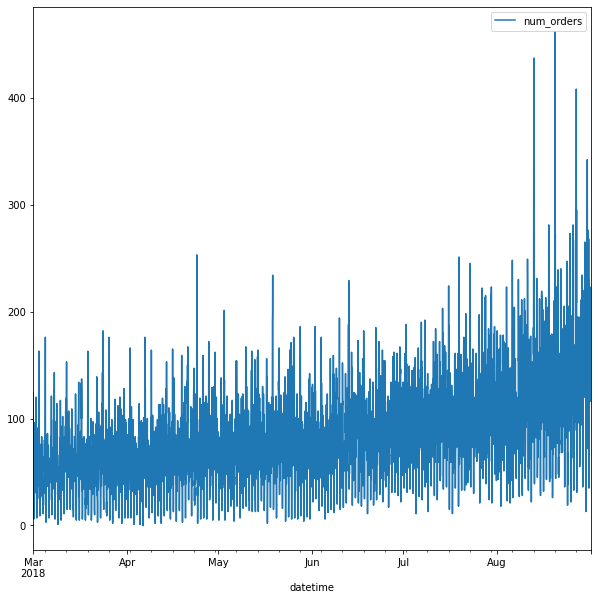

In [10]:
df.plot(figsize=(10, 10))

Получилась очень "концентрированная" гистограма, делаем ее более наглядной, ввыведем количество заказов в день за один день с помощью свойств формата datetime:

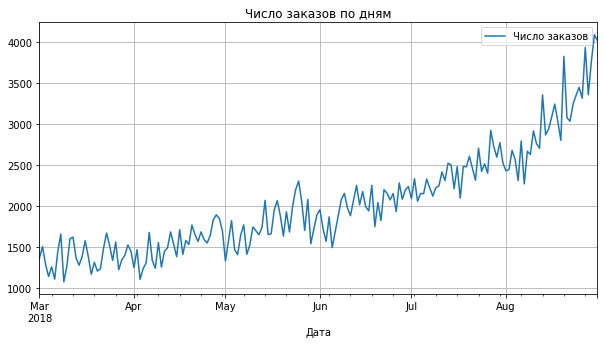

In [11]:
df.resample('1D').sum().plot(figsize=(10, 5), grid=True)
plt.title('Число заказов по дням')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

На гистограме отображаются данные с начала марта по конец августа. Несмотря на периодические колебания, заметен рост заказов к концу представленного периода. Видимо, этот подъем имеет сезонный характер. 


### decomposed

С помощью метода *seasonal_decompose* формируем переменную, раскладывающую исходные данные на *тренд, сезонность* и *случайные колебания*. Последовательно визуализируем характеристики.

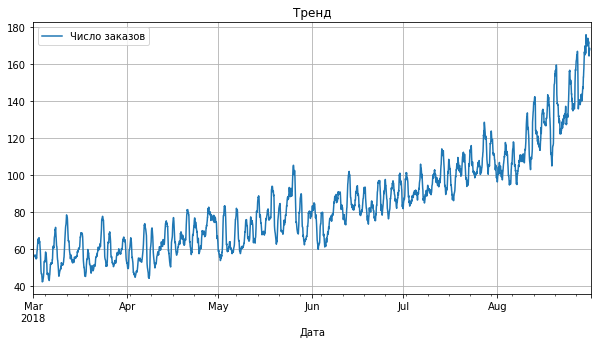

In [12]:
decomposed = seasonal_decompose(df['num_orders'].resample('1H').sum())

decomposed.trend.plot(figsize=(10, 5), grid=True)
plt.title('Тренд')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

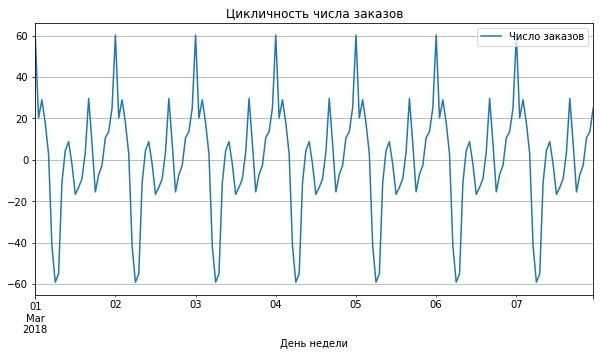

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(10, 5), grid=True)
plt.title('Цикличность числа заказов')
plt.legend(['Число заказов'])
plt.xlabel('День недели');

Видно, что цикл занимает период в сутки. Уменьшаем диапазон до дня:

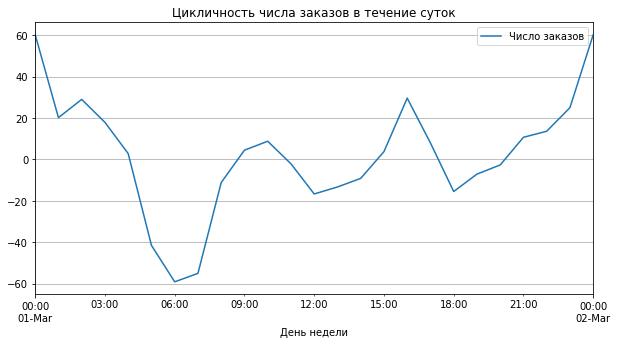

In [15]:
decomposed.seasonal['2018-03-01 00:00':'2018-03-02 00:00'].plot(figsize=(10, 5), grid=True)
plt.title('Цикличность числа заказов в течение суток')
plt.legend(['Число заказов'])
plt.xlabel('День недели');

Можно сделать вывод, что пик заказов приходится на время около полуночи. А наименьшее число - в районе шести утра. Так же, активность повышается в районе 9:30-10:00 и  16:00. Вероятно, это можно связать с рабочими графиками и поздним досугом.

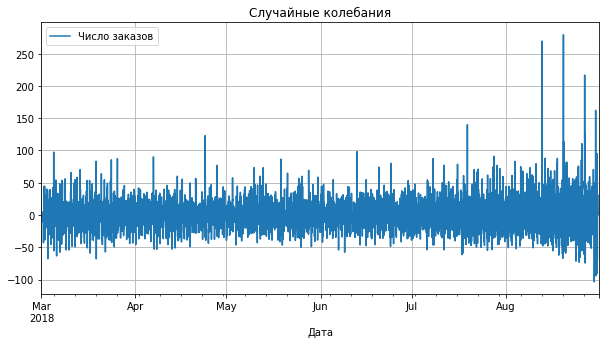

In [16]:
decomposed.resid.plot(figsize=(10, 5), grid=True)
plt.title('Случайные колебания')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

### Скользящее среднее

Чтобы подтвердить или опровергнуть выводы, полученные с помощью *decomposed*, рассмотрим данные с помощью оценки с использованием скользящего среднего.

<div><font size=2, color=gray> Для себя: </font></div>

> Метод скользящей средней – один из методов статистического прогнозирования, которое применяется в случаях, когда имеющиеся данные динамического ряда могут не позволить обнаружить какую-либо тенденцию развития (тренд) того или иного процесса (из-за случайных и периодических колебаний исходных данных). В таких случаях для лучшего выявления тенденции прибегают к методу скользящей средней. Метод скользящей средней состоит в замене фактических уровней динамического ряда расчетными, имеющими значительно меньшую колеблемость, чем исходные данные. При этом средняя рассчитывается по группам данных за определенный интервал времени, причем каждая последующая группа образуется со сдвигом на один интервал. В результате подобной операции первоначальные колебания динамического ряда сглаживаются, поэтому и операция называется сглаживанием рядов динамики (основная тенденция развития выражается при этом уже в виде некоторой плавной линии).

Напишем функцию для вычисления и  визуализации *rolling_mean*, а так же доверительного интервала и аномальных значений:

In [17]:
rolling_mean_per = []
def plotMovingAverage(series,  window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()
    

    plt.figure(figsize=(15,5))
    plt.title("Скользящее среднее\n размер окна = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
      
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    

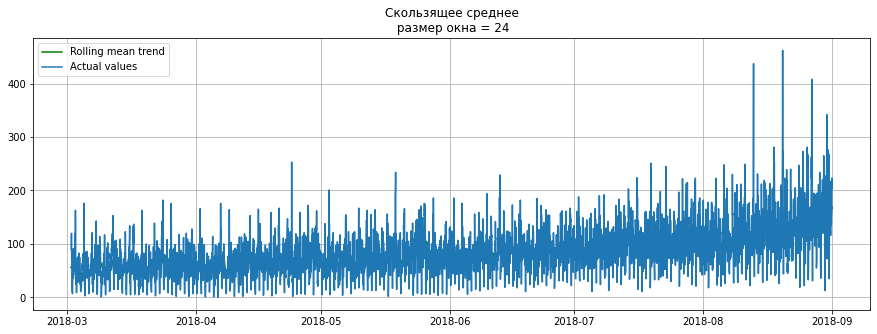

In [18]:
plotMovingAverage(df, 24)

Т к график достаточно плотный, ресемплируем до дней и выведем недельный тренд с доверительными интервалами:


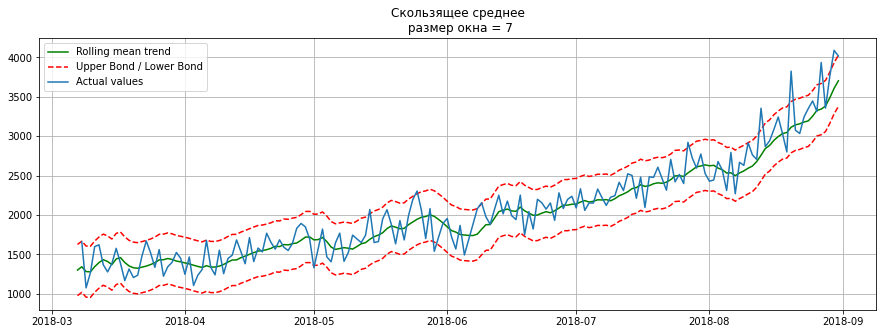

In [19]:
df_daily = df.resample('1D').sum()
#plotMovingAverage(df_daily, 7)
plotMovingAverage(df_daily, 7, True, True)

Явных аномальных значений не обнаружилось.

***Создадим переменные с данными за первый месяц, последний и за временой интервал посередине:***

In [20]:
march = df['2018-03-01': '2018-03-31']
median = df['2018-05-15': '2018-06-14']
august = df['2018-08-01': '2018-08-31']

***Далее последовательно визуализируем:***

***March***

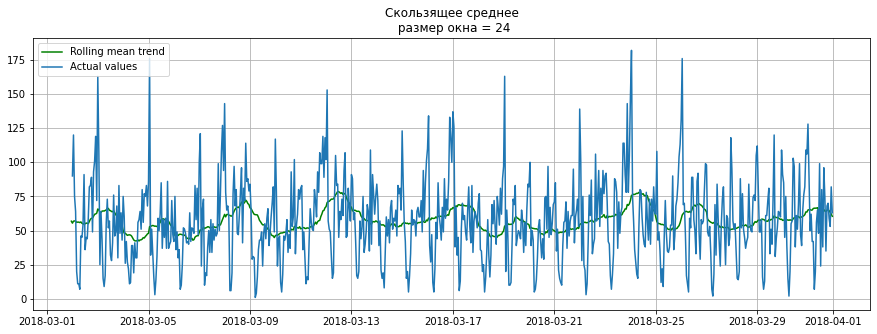

In [21]:
plotMovingAverage(march, 24)

**Середина временного отрезка**



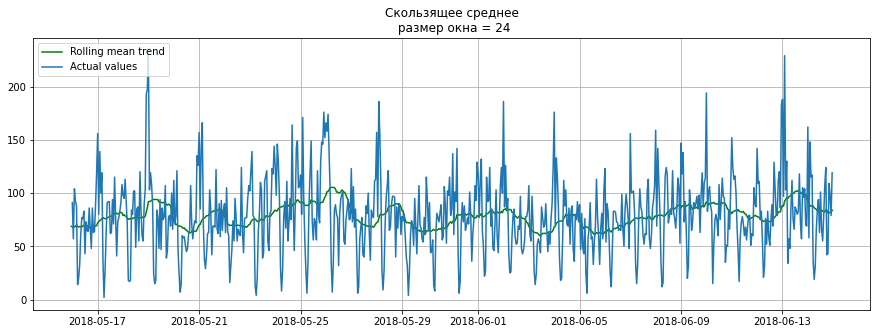

In [22]:
plotMovingAverage(median, 24)

**August**

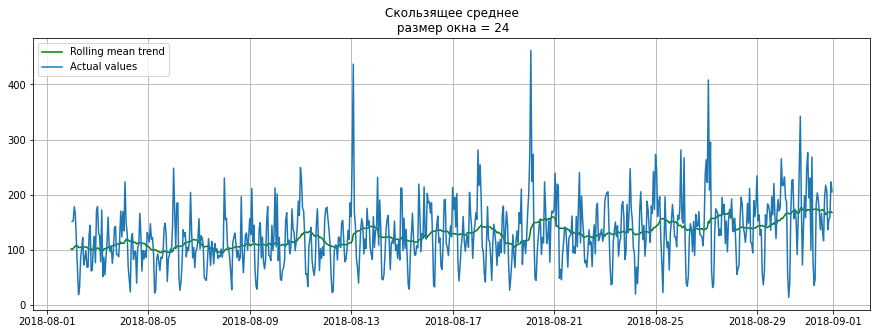

In [23]:
plotMovingAverage(august, 24)


**Сформируем таблицу с максимальным, минимальным и средним значениями скользящего среднего количества заказов по временным отрезкам.**


In [24]:
def rolling_mean(series,  window):
    rolling_mean = series.rolling(window=window).mean()
    mean_r = rolling_mean['num_orders'].mean()
    return round(mean_r, 2)
    
def rolling_min(series,  window):
    rolling_mean = series.rolling(window=window).mean()
    min_r = rolling_mean['num_orders'].min()
    return round(min_r, 2)
    
def rolling_max(series,  window):
    rolling_mean = series.rolling(window=window).mean()
    max_r = rolling_mean['num_orders'].max()
    return round(max_r, 2)
    
rolling_tab = pd.DataFrame(np.array([
        
        [ rolling_min(march, 24), rolling_min(median, 24), rolling_min(august, 24)],
        [ rolling_max(march, 24), rolling_max(median, 24), rolling_max(august, 24)],
        [ rolling_mean(march, 24), rolling_mean(median, 24), rolling_mean(august, 24)]]), 
                           index=['min', 'max', 'mean'], 
                           columns=[ 'march', 'median', 'august']).T

rolling_tab
#визуализировать особого смысла не вижу, итак вполне наглядно


,min,max,mean
march,42.38,78.67,57.46
median,59.67,105.33,78.85
august,94.46,176.92,127.40


**Вывод:**
- В марте колебания значений среднего скользящего были  в диапазоне от 42 до 78 заказов.
- На период, сооответствующий середине преждложенного временного интервала, колебания значений среднего скользящего были примерно в диапазоне от 60 до 105 заказов.
- В августе отмечается значительный поъем количества заказов относительно предыдущих периодов с тенденцией к нарастанию к концу месяца. Так, с 94 заказов идет нарастание до 127.
- существенных аномалий не обнаружено.
- прослеживается явное сезонное нарастание спроса с 57 в марте до 127 в августе.

Таким образом, выводы методом *decomposed* подтверждаются и детализируются методом скользящего среднего.

### Общий вывод

При визуализации данных заметен рост заказов к концу представленного периода. Видимо, этот подъем связан с концом лета и сопутствующими событиями. 
При анализе  с помощью метода *seasonal_decompose*  исходные данные были разбиты  на тренд, сезонность и случайные колебания. Выполнена визуализация. Далее был проведен анализ методом скользящего среднего.

Результаты обоими способами не противоречат друг другу и дополняют.
- Пик заказов приходится на время около полуночи. А наименьшее число - в районе шести утра. Так же, активность повышается в районе 9:30-10:00 и 16:00. Вероятно, это можно связать с рабочими графиками и поздним досугом.
- пик заказов приходится на время около полуночи. А наименьшее число - в районе шести утра. Так же, активность повышается в районе 9:30-10:00 и 16:00. Вероятно, это можно связать с рабочими графиками и поздним досугом;
- цикл колебаний составляет сутки;
- В марте колебания значений среднего скользящего были  в диапазоне от 42 до 78 заказов.
- На период, сооответствующий середине преждложенного временного интервала, колебания значений среднего скользящего были примерно в диапазоне от 60 до 105 заказов.
- В августе отмечается значительный поъем количества заказов относительно предыдущих периодов с тенденцией к нарастанию к концу месяца. Так, с 94 заказов идет нарастание до 127.
- существенных аномалий не обнаружено.
- прослеживается явное сезонное нарастание спроса с 57 в марте до 127 в августе.


## Обучаем модель
### Разбиваем на выборки, выделяем целевой признак

In [25]:
data=df.copy()

Напишем функцию, которая создаст дополнительные признаки для обучения: месяц, день месяца, день недели и час, а так же добавит отстающие значения и скользящее среднее. 

По этому дополнительному набору данных модель сможет сделать предсказания более точными.


In [26]:
def make_features(data, max_lag, rolling_mean_size):
    # Календарные признаки
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

Определяем временное окно для скользящего среднего в 24ч - дневной тренд. Т к ранее мы определили некий суточный цикл заказов.

In [27]:
make_features(data, 1, 24)
data.head()

,num_orders,month,dayofweek,is_weekend,hour,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,3,0,0,NaN,NaN
2018-03-01 01:00:00,85,3,3,0,1,124.0,NaN
2018-03-01 02:00:00,71,3,3,0,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,0,3,71.0,NaN
2018-03-01 04:00:00,43,3,3,0,4,66.0,NaN


Проверим новую таблицу на наличие пропуков:

In [28]:
data.isna().sum()

num_orders       0
month            0
dayofweek        0
is_weekend       0
hour             0
lag_1            1
rolling_mean    24
dtype: int64

Чтобы не потерять данные - для заполнения Nan-значений скользящего среднего из-за невозможности его высчитать, которые образуются в начале датафрейма, используем среднее значение rolling_mean за март. Пропуск в лаге так же заполним средним.


In [29]:
print('Оценим статистику по скользящему среднему:',  data['rolling_mean'][ '2018-03-01': '2018-03-31'].describe(), sep='\n')
print()
print('Среднее среднее скользящее за март = ',  round(data['rolling_mean'][ '2018-03-01': '2018-03-31'].mean(), 2))
print()
print('Статистика по лагам:', data['lag_1'][ '2018-03-01': '2018-03-31'].describe(), sep='\n')
print()
print('Среднее lag_1 за март = ',  round(data['lag_1'][ '2018-03-01': '2018-03-31'].mean(), 2))
data['rolling_mean']=data['rolling_mean'].fillna(round(data['rolling_mean'][ '2018-03-01': '2018-03-31'].mean(), 2))
data['lag_1']=data['lag_1'].fillna(data['lag_1'][ '2018-03-01': '2018-03-31'].mean())

Оценим статистику по скользящему среднему:
count    720.000000
mean      57.451157
std        7.682692
min       42.375000
25%       52.156250
50%       56.312500
75%       62.177083
max       78.666667
Name: rolling_mean, dtype: float64

Среднее среднее скользящее за март =  57.45

Статистика по лагам:
count    743.000000
mean      57.476447
std       29.581660
min        1.000000
25%       39.000000
50%       55.000000
75%       75.000000
max      182.000000
Name: lag_1, dtype: float64

Среднее lag_1 за март =  57.48


### Разделение данных

Нам необходимо проверить модель на правильные предсказания с вычислением метрик на уже обученной тестовой модели. Согласно условию заданияЮ для этого мы разделим общую выборку на 2 части в соотношении (90/10): обучающую и тестовую, без валидационной.  Так же, следует сохранить хронологческий порядок, используем атрибут  *shuffle=False*.

In [30]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)


In [31]:
train.head()

,num_orders,month,dayofweek,is_weekend,hour,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,3,0,0,57.476447,57.45
2018-03-01 01:00:00,85,3,3,0,1,124.000000,57.45
2018-03-01 02:00:00,71,3,3,0,2,85.000000,57.45
2018-03-01 03:00:00,66,3,3,0,3,71.000000,57.45
2018-03-01 04:00:00,43,3,3,0,4,66.000000,57.45


Формируем функцию, которая разделит данные на целевой признак и признаки:


In [32]:
def target_features_split(data,column):
    return data[column], data.drop(column,axis=1)

target_train, features_train = target_features_split(train, 'num_orders')
target_test, features_test = target_features_split(test, 'num_orders')

Мы добавили признаки: Календарные, Отстающие значения, Скользящее среднее. Также, разделили общую выборку на 2 части в соотношении (90/10): обучающую, тестовую. Отделили целевой признак.

## Тестирование


Рассмотрим разные модели регрессии: Линейная регрессия, Дерево решений, Рандомный лес. Также построим модели бустингов. 
<br>*Искомые метрики: RMSE,MAPE*
<br>Найдем их при тренировочной и тестовой выборках, так же, определим время, затраченное моделями на обучение и предсказание. Сформируем датафрейм с необходимыми данными.


In [33]:
models_stats = dict()
tscv = TimeSeriesSplit(n_splits=8)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


random_state_val = 1234

In [34]:
def evaluate_model(model_name, model, train_features, train_target, test_features, test_target, parameters=None):
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    print()
    
    # генерируем предсказания
    start_time = time.perf_counter()
    predicted_test = model.predict(test_features)
    finish_time = time.perf_counter()
    
    fit_time = (finish_time - start_time)

    
    start_time = time.perf_counter()
    predicted_train = model.predict(train_features)
    finish_time = time.perf_counter()
    predict_time = (finish_time - start_time)
    
    # MSE 
    mse_test = mean_squared_error(test_target, predicted_test)
    mse_train = mean_squared_error(train_target, predicted_train)
    # MAPE 
    mape_test = mean_absolute_percentage_error(predicted_test, test_target)
    mape_train = mean_absolute_percentage_error(predicted_train, train_target)
    # RMSE 
    rmse_test = mse_test ** 0.5
    rmse_train = mse_train ** 0.5
    # вывод значений метрик и времени
    print(f'RMSE модели на тестовой выборке: {rmse_test}')
    print(f'RMSE модели на обучающей выборке: {rmse_train}')
    print(f'MAPE модели на тестовой выборке: {mape_test}')
    print(f'MAPE модели на обучающей выборке: {mape_train}')
    print(f'Время обучения модели: {fit_time}')
    print(f'Время предсказания модели: {predict_time}')
    
    models_stats[model_name] = {
        'название': model_name,
        'rmse_train':rmse_train,
        'rmse_test':rmse_test,
        'mape_train':mape_train,
        'mape_test':mape_test,
        'fit_time': fit_time,
        'predict_time': predict_time
    }
    print()

### Dummy

In [35]:
dummy_model = DummyRegressor(strategy="constant", constant=target_train.median())
dummy_model.fit(features_train,target_train)
evaluate_model('Дамми модель', dummy_model, features_train, target_train, features_test, target_test)

Оценка модели: Дамми модель

RMSE модели на тестовой выборке: 87.15277582981295
RMSE модели на обучающей выборке: 38.806713291350775
MAPE модели на тестовой выборке: 94.3891402714932
MAPE модели на обучающей выборке: 39.60174467371246
Время обучения модели: 0.0001625455915927887
Время предсказания модели: 0.0003619980998337269



### Линейная Регрессия

In [36]:
%%time
linear_model = LinearRegression()
start_time = time.perf_counter()
linear_model.fit(features_train, target_train)
finish_time = time.perf_counter()
lr_fit_time = (finish_time - start_time)
evaluate_model("Линейная регрессия", linear_model, features_train, target_train, features_test, target_test)

lr_fit_time

Оценка модели: Линейная регрессия

RMSE модели на тестовой выборке: 51.72571428291327
RMSE модели на обучающей выборке: 30.733625234408777
MAPE модели на тестовой выборке: 30.7972380005947
MAPE модели на обучающей выборке: 31.458207024727315
Время обучения модели: 0.0013584648258984089
Время предсказания модели: 0.0631377650424838

CPU times: user 51.9 ms, sys: 35.3 ms, total: 87.2 ms
Wall time: 72.2 ms


0.003200545907020569

### Дерево Решений

In [37]:
%%time

best_decision_tree_model = None
best_decision_tree_result = 100
best_decision_tree_depth = 0
best_decision_tree_leaf = 0

#подбираем гиперпараметры, обучаем модель, вычисляем метрики
for depth in range(1,25):
    for leaf in range(1,25):
        model = DecisionTreeRegressor(random_state=random_state_val, max_depth=depth,min_samples_leaf=leaf)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_decision_tree_model = model
            best_decision_tree_result = rmse
            best_decision_tree_depth = depth
            best_decision_tree_leaf = leaf

evaluate_model("Decision Tree", best_decision_tree_model, features_train, target_train, features_test, target_test, {'depth': best_decision_tree_depth, 'leaf': best_decision_tree_leaf})


Оценка модели: Decision Tree
с параметрами: {'depth': 11, 'leaf': 7}

RMSE модели на тестовой выборке: 45.84335105805274
RMSE модели на обучающей выборке: 19.59520421956937
MAPE модели на тестовой выборке: 30.36143655885101
MAPE модели на обучающей выборке: 20.183839670000744
Время обучения модели: 0.0017120293341577053
Время предсказания модели: 0.0017185811884701252

CPU times: user 5.49 s, sys: 30.1 ms, total: 5.52 s
Wall time: 5.53 s


### Рандомный лес

In [38]:
%%time
best_randomforest_model = None
best_randomforest_result = 100
best_num_trees = 0
best_randomforest_depth = 0
for est in range(10,61,10):
    for depth in range(1,21):
        model = RandomForestRegressor(random_state=random_state_val, n_estimators=est,max_depth=depth)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_randomforest_model = model
            best_randomforest_result = rmse
            best_num_trees = est
            best_randomforest_depth = depth
            
            
evaluate_model("Decision Tree", best_decision_tree_model, features_train, target_train, features_test, target_test, {'depth': best_decision_tree_depth, 'leaf': best_decision_tree_leaf})


Оценка модели: Decision Tree
с параметрами: {'depth': 11, 'leaf': 7}

RMSE модели на тестовой выборке: 45.84335105805274
RMSE модели на обучающей выборке: 19.59520421956937
MAPE модели на тестовой выборке: 30.36143655885101
MAPE модели на обучающей выборке: 20.183839670000744
Время обучения модели: 0.0018897787667810917
Время предсказания модели: 0.0015366990119218826

CPU times: user 26.1 s, sys: 108 ms, total: 26.2 s
Wall time: 26.3 s


### ElasticNet

In [39]:
%%time
best_model_elastic = None
best_result_elastic = 100
best_alpha = None
best_l1_ratio = None
elastic_alpha = [10, 100, 1000,10000]
elastic_l1_ratio = [0, 0.25, 0.5, 0.75,1]

for alpha_ in elastic_alpha:
    for l1_ratio_ in elastic_l1_ratio:
        model = ElasticNet(random_state=random_state_val,alpha=alpha_, l1_ratio=l1_ratio_)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_result_elastic > rmse:
            best_result_elastic = rmse
            best_model_elastic = model
            best_alpha = alpha_
            best_l1_ratio = l1_ratio_
        
print("Точность лучшей модели ElasticNet на тестовой выборке - RMSE:",best_result_elastic)
print()
evaluate_model("ElasticNet", best_model_elastic, features_train, target_train, features_test, target_test, {'l1_ratio': best_l1_ratio, 'alpha': best_alpha})


Точность лучшей модели ElasticNet на тестовой выборке - RMSE: 51.2642384307466

Оценка модели: ElasticNet
с параметрами: {'l1_ratio': 0.25, 'alpha': 10}

RMSE модели на тестовой выборке: 51.2642384307466
RMSE модели на обучающей выборке: 30.88729652669745
MAPE модели на тестовой выборке: 29.701217440683696
MAPE модели на обучающей выборке: 31.57590469291085
Время обучения модели: 0.001999789848923683
Время предсказания модели: 0.09339345572516322

CPU times: user 830 ms, sys: 1.05 s, total: 1.88 s
Wall time: 1.86 s


### LightGBM


In [40]:
%%time

best_lightgbm_model = None
best_lightgbm_result = 100
best_lightgbm_objective = ''
best_lightgbm_boosting_type = ''
best_lightgbm_num_leaves = 0
best_lightgbm_max_depth = 0
for depth in [15,20,25,30,50]:
    for leaves in [10,100,200,300]:
        for objective in ['regression','binary']:
            for boosting_type in ['dart', 'gbdt','goss']:
                model = lgb.LGBMRegressor(n_jobs=-1,boosting_type=boosting_type, num_leaves=leaves, max_depth=depth, objective=objective)
            
                model.fit(features_train, target_train)
                predicted_test = model.predict(features_test)
                mse = mean_squared_error(target_test, predicted_test)
                rmse = mse ** 0.5
                if best_lightgbm_result > rmse:
                    best_lightgbm_model = model
                    best_lightgbm_result = rmse
                    best_lightgbm_objective = objective
                    best_lightgbm_boosting_type = boosting_type
                    best_lightgbm_num_leaves = leaves
                    best_lightgbm_max_depth = depth
evaluate_model("LightGBM", best_lightgbm_model, features_train, target_train, features_test, target_test, {'depth': best_lightgbm_max_depth,
                                                                                                           'num_leaves': best_lightgbm_num_leaves,
                                                                                                            'objective': best_lightgbm_objective,
                                                                                                            'boosting_type': best_lightgbm_boosting_type})


Оценка модели: LightGBM
с параметрами: {'depth': 15, 'num_leaves': 200, 'objective': 'regression', 'boosting_type': 'goss'}

RMSE модели на тестовой выборке: 43.04941494638241
RMSE модели на обучающей выборке: 16.328942978823235
MAPE модели на тестовой выборке: 26.62982964123853
MAPE модели на обучающей выборке: 17.713559291141074
Время обучения модели: 0.006486097816377878
Время предсказания модели: 0.09033773792907596

CPU times: user 18min 36s, sys: 8.78 s, total: 18min 45s
Wall time: 18min 54s


### XGBoost

In [41]:
%%time

best_xgboost_model = None
best_xgboost_result = 100
best_xgboost_depth = 0
best_xgboost_estimators = 0
for depth in range(3,20,2):
    for estimators in range(1,24,2):
        model = xgb.XGBRegressor(n_jobs=-1,n_estimators=estimators,max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_xgboost_result > rmse:
            best_xgboost_model = model
            best_xgboost_result = rmse
            best_xgboost_depth = depth
            best_xgboost_estimators = estimators
evaluate_model("XGBoost", best_xgboost_model, features_train, target_train, features_test, target_test, {'depth': best_xgboost_depth, 'n_estimators': best_xgboost_estimators})


Оценка модели: XGBoost
с параметрами: {'depth': 5, 'n_estimators': 23}

RMSE модели на тестовой выборке: 45.17898568585264
RMSE модели на обучающей выборке: 18.052392027174882
MAPE модели на тестовой выборке: 29.617219890487462
MAPE модели на обучающей выборке: 19.93700256782916
Время обучения модели: 0.004586041904985905
Время предсказания модели: 0.004731736145913601

CPU times: user 1min 17s, sys: 377 ms, total: 1min 17s
Wall time: 1min 18s


### CatBoost

In [42]:
%%time
best_catboost_model = None
best_catboost_result = 100
best_catboost_l2_leaf_reg = 0
best_catboost_max_depth = 0
for depth in [5,10]:
    for l2_reg in [1,2,3]:
        model = CatBoostRegressor(loss_function='RMSE',random_state=random_state_val,silent=True,l2_leaf_reg=l2_reg, depth=depth)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_catboost_result > rmse:
            best_catboost_model = model
            best_catboost_result = rmse
            best_catboost_l2_leaf_reg = l2_reg
            best_catboost_max_depth = depth
evaluate_model("CatBoost", best_catboost_model, features_train, target_train, features_test, target_test, {'depth': best_catboost_max_depth,
                                                                                                           'l2_leaf_reg': best_catboost_l2_leaf_reg})



Оценка модели: CatBoost
с параметрами: {'depth': 5, 'l2_leaf_reg': 2}

RMSE модели на тестовой выборке: 43.7072221412311
RMSE модели на обучающей выборке: 17.837515435729834
MAPE модели на тестовой выборке: 27.771599964077286
MAPE модели на обучающей выборке: 19.81874963792924
Время обучения модели: 0.0013720430433750153
Время предсказания модели: 0.005065858829766512

CPU times: user 19.6 s, sys: 627 ms, total: 20.3 s
Wall time: 24.5 s


### Сводная таблица результатов

In [43]:
stats= pd.DataFrame(models_stats).T 
stats



,название,rmse_train,rmse_test,mape_train,mape_test,fit_time,predict_time
Дамми модель,Дамми модель,38.806713,87.152776,39.601745,94.38914,0.000163,0.000362
Линейная регрессия,Линейная регрессия,30.733625,51.725714,31.458207,30.797238,0.001358,0.063138
Decision Tree,Decision Tree,19.595204,45.843351,20.18384,30.361437,0.00189,0.001537
ElasticNet,ElasticNet,30.887297,51.264238,31.575905,29.701217,0.002,0.093393
LightGBM,LightGBM,16.328943,43.049415,17.713559,26.62983,0.006486,0.090338
XGBoost,XGBoost,18.052392,45.178986,19.937003,29.61722,0.004586,0.004732
CatBoost,CatBoost,17.837515,43.707222,19.81875,27.7716,0.001372,0.005066


**Оставим модели, удовлеворяющие условию rmse_test < 48 на тестовой выборке:**


In [44]:
stats_true = stats.query("rmse_test < 48")
stats_true


,название,rmse_train,rmse_test,mape_train,mape_test,fit_time,predict_time
Decision Tree,Decision Tree,19.595204,45.843351,20.18384,30.361437,0.00189,0.001537
LightGBM,LightGBM,16.328943,43.049415,17.713559,26.62983,0.006486,0.090338
XGBoost,XGBoost,18.052392,45.178986,19.937003,29.61722,0.004586,0.004732
CatBoost,CatBoost,17.837515,43.707222,19.81875,27.7716,0.001372,0.005066


Показали необходимый результат: *Decision Tree*, *XGBoost*, *LightGBM*, *CatBoost*.	

Визуализируем метрику RMSE, а так же время обучения и предсказания.

,название,rmse_test
0,LightGBM,43.049415
1,CatBoost,43.707222
2,XGBoost,45.178986
3,Decision Tree,45.843351


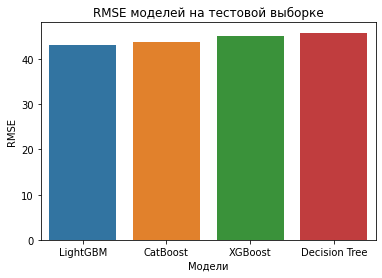

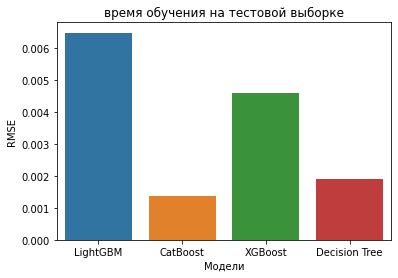

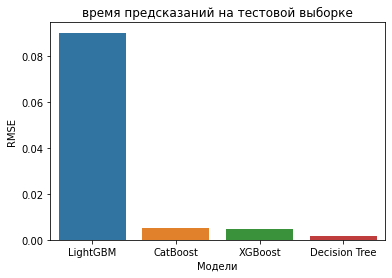

In [45]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
rmse_sorted = stats_true.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_sorted[['название','rmse_test']])


drawPlot(rmse_sorted, 'название','rmse_test','Модели','RMSE','RMSE моделей на тестовой выборке','название' )
drawPlot(rmse_sorted, 'название','fit_time','Модели','RMSE','время обучения на тестовой выборке','название' )
drawPlot(rmse_sorted, 'название','predict_time','Модели','RMSE','время предсказаний на тестовой выборке','название' )


Лучше всех себя показали модели **LightGBM** и **CatBoost**. Однако, если сравнивать временные показатели, CatBoost справляется значительно быстрее. Исходя из того, что предсказания требуются в коротких временных рамках(на следующий час), предпочтительней использовать эту модель.	

## Вывод.

Был открыт и изучен датафрейм: изначально он состоял из 26496 строк и двух столбцов - типа datetime с интервалом в 10 минут и количеством заказов, приходящимся на это время. Охваченный временной интервал: 2018-03-01 00:00:00 по 2018-08-31 23:00:00, т е 6 месяцев. На этапе предобработки столбец datetime был установлен как индекс для удобства работы с датасетом. Пропущенных значений и дубликатов не обнаружено. Данные расположены в хронологическом порядке. Т к требуются предсказания на следующий час, было проведено ресемплирование данных на интервал в 1 час.

При визуализации данных заметен рост заказов к концу представленного периода. Видимо, этот подъем связан с концом лета и сопутствующими событиями. 
При анализе  с помощью метода *seasonal_decompose*  исходные данные были разбиты  на тренд, сезонность и случайные колебания. Выполнена визуализация. Далее был проведен анализ методом скользящего среднего.

Результаты обоими способами не противоречат друг другу и дополняют.
- Пик заказов приходится на время около полуночи. А наименьшее число - в районе шести утра. Так же, активность повышается в районе 9:30-10:00 и 16:00. Вероятно, это можно связать с рабочими графиками и поздним досугом.
- пик заказов приходится на время около полуночи. А наименьшее число - в районе шести утра. Так же, активность повышается в районе 9:30-10:00 и 16:00. Вероятно, это можно связать с рабочими графиками и поздним досугом;
- цикл колебаний составляет сутки;
- В марте колебания значений среднего скользящего были  в диапазоне от 42 до 78 заказов.
- На период, сооответствующий середине преждложенного временного интервала, колебания значений среднего скользящего были примерно в диапазоне от 60 до 105 заказов.
- В августе отмечается значительный поъем количества заказов относительно предыдущих периодов с тенденцией к нарастанию к концу месяца. Так, с 94 заказов идет нарастание до 127.
- существенных аномалий не обнаружено.
- прослеживается явное сезонное нарастание спроса с 57 в марте до 127 в августе.

Согласно условию *rmse_test < 48 на тестовой выборке* , показали необходимый результат: *Decision Tree, XGBoost, LightGBM, CatBoost.*

Лучше всех себя показали модели **LightGBM** и **CatBoost**. Однако, если сравнивать временные показатели, ***CatBoost*** справляется значительно быстрее. Исходя из того, что предсказания требуются в коротких временных рамках(на следующий час), предпочтительней использовать эту модель.	